In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import geopy.distance
import os
import plotly.graph_objects as go
from shapely.geometry import shape, Point
import seaborn as sns
import matplotlib as mpl
import folium
import re
import seaborn as sns
from datetime import datetime
import pytz
from pytz import timezone
from google.colab import drive
import datetime
from datetime import timedelta
from google.colab import drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/SevenStates_project/Session-Details-Summary-20240119-3.xlsx')

Mounted at /content/drive


In [ ]:
def convert_duration_to_seconds(duration):
    if isinstance(duration, str):
        parts = duration.split(':')
        hours = int(parts[0])
        minutes = int(parts[1])
        seconds = int(parts[2].split()[0])  # Extract seconds and ignore 'AM' or 'PM'
        total_seconds = hours * 3600 + minutes * 60 + seconds
        return total_seconds
    elif isinstance(duration, datetime.time):
        return duration.hour * 3600 + duration.minute * 60 + duration.second
    else:
        return 0

def convert_to_est(row, date_col, tz_col):
    tz_map = {'EST': 'America/New_York', 'CST': 'America/Chicago', 'CDT': 'America/Chicago', 'EDT': 'America/New_York', 'PDT': 'America/Los_Angeles', 'PST': 'America/Los_Angeles'}
    return row[date_col].tz_localize(tz=tz_map[row[tz_col]], ambiguous='NaT').tz_convert(tz='EST')

missing_count = df['Port Type'].value_counts().get('Missing', 0)
# Convert Start and End Date to datetime
df['Start Date'] = pd.to_datetime(df['Start Date'])
df['End Date'] = pd.to_datetime(df['End Date'])


# Apply function to Start and End Date
df['Start_Time_EST'] = df.apply(convert_to_est, args=('Start Date', 'Start Time Zone'), axis=1)
df['End_Time_EST'] = df.apply(convert_to_est, args=('End Date', 'End Time Zone'), axis=1)

#sorting
df=df.sort_values(by=['EVSE ID', 'Start_Time_EST'])
#correct station name
df['Station Name'] = df['Station Name'].replace({"7SPC / BR-JC LIBRARY": "7SPC / BR-JC LIBRARY_combined","7SPC / BR - JC LIBRARY": "7SPC / BR-JC LIBRARY_combined"})

#convert total duration to second
df['Total Duration'] = df['Total Duration (hh:mm:ss)'].apply(convert_duration_to_seconds)
df['Charging Time'] = df['Charging Time (hh:mm:ss)'].apply(convert_duration_to_seconds)

# parking time
df.loc[df['Charging Time'] > df['Total Duration'], 'Charging Time'] = df['Total Duration']
df['parking_time'] = df['Total Duration'] - df['Charging Time']



# wich day of week
df['Day_of_Week'] = df['Start_Time_EST'].dt.dayofweek

# Create new columns 'Is_Weekday' and 'Is_Weekend'
df['Is_Weekday'] = df['Day_of_Week'].isin([0, 1, 2, 3, 4]).astype(int)
df['Is_Weekend'] = df['Day_of_Week'].isin([5, 6]).astype(int)

# Create new columns 'DC' and 'L2'
df['DC'] = (df['Port Type'] == 'DC Fast').astype(int)
df['L2'] = (df['Port Type'] == 'Level 2').astype(int)
df['Port Type'] = df['Port Type'].fillna('')
#sorting data
df['Start_Time_EST']=pd.to_datetime(df['Start_Time_EST'])
df=df.sort_values(by=['EVSE ID', 'Start_Time_EST'])

Index(['Address 1', 'Address 2', 'Charging Time', 'Charging Time (hh:mm:ss)',
       'City', 'Country', 'County', 'Currency', 'DC', 'Day_of_Week',
       'Driver Zip/Postal Code', 'EVSE ID', 'End Date', 'End SOC',
       'End Time Zone', 'End_Time_EST', 'Ended By', 'Energy (kWh)', 'Fee',
       'GHG Savings (kg)', 'Gasoline Savings (gallons)', 'Is_Weekday',
       'Is_Weekend', 'L2', 'Latitude', 'Longitude', 'MAC Address',
       'Model Number', 'OnRamp ID Tag', 'Org Name',
       'Payment Terminal Session ID', 'Plug In Event ID', 'Plug Type',
       'Port Number', 'Port Type', 'Start Date', 'Start SOC',
       'Start Time Zone', 'Start_Time_EST', 'State/Province', 'Station Name',
       'System S/N', 'Total Duration', 'Total Duration (hh:mm:ss)',
       'Transaction Date (Pacific Time)', 'Transaction ID', 'User ID',
       'Vehicle MAC ID', 'Zip/Postal Code', 'parking_time'],
      dtype='object')

*** c alculate the time difference between the start time of the current session and the end time of the previous one***

start time  -->  end time

duration = end - start

charging time = end of charging - start

parking time = end - end of charging = duration - charging

end of charging = start + chartging time

In [ ]:

df['Charging Time'] = df['Charging Time (hh:mm:ss)'].apply(lambda x: pd.Timedelta(hours=x.hour, minutes=x.minute, seconds=x.second))
#df['Charging Time (hh:mm:ss)'] = df['Charging Time (hh:mm:ss)'].apply(lambda x: pd.to_timedelta(x.strftime('%H:%M:%S')) if x != datetime.time(0, 0) else pd.Timedelta(seconds=0))


df['End_Charging_Time_EST'] = df['Start_Time_EST'] + df['Charging Time']

#df['End_Charging_Time_EST'] = [date + timedelta(seconds=chargingtime) for date, chargingtime in df[['Start_Time_EST','Charging Time']].itertuples(index=False)]


df['End_Time_EST'] = pd.to_datetime(df['End_Time_EST'], utc=True).dt.tz_convert('EST')
df['Start_Time_EST'] = pd.to_datetime(df['Start_Time_EST'], utc=True).dt.tz_convert('EST')

df['previous_end_time'] = df.groupby(['EVSE ID','Port Number'])['End_Time_EST'].shift(1)
# df=df.dropna(subset='previous_end_time')

#df['Event Type'] = 'Parking/Charging'


df_idle = df.copy()
df_idle['Start_Time_EST_2'] = df_idle['previous_end_time']
df_idle['End_Time_EST_2'] = df_idle['Start_Time_EST']
df_idle['Event Type'] = 'Idle'
df_idle['User ID'] = np.nan
df_idle["Start SOC"]=np.nan
df_idle["End SOC"]=np.nan
df_idle["Energy (kWh)"]= 0
df_idle["GHG Savings (kg)"]= 0
df_idle["Gasoline Savings (gallons)"]= 0
df_idle["Fee"]=np.nan
df_idle["Ended By"]='Start Of New Event'
df_idle['Event_Duration'] = df_idle['Start_Time_EST']-df_idle['previous_end_time']
df_idle['Vehicle MAC ID'] = np.nan
df_idle['Model Number'] = np.nan
df_idle['Driver Zip/Postal Code'] = np.nan
df_idle['Transaction ID'] = np.nan




df_charging = df.copy()
df_charging['Start_Time_EST_2'] = df_charging['Start_Time_EST']
df_charging['End_Time_EST_2'] = df_charging['End_Charging_Time_EST']
df_charging['Event Type'] = 'Charging'
df_charging['User ID'] = df_charging['User ID']
df_charging["Start SOC"]=df_charging["Start SOC"]
df_charging["End SOC"]=df_charging["End SOC"]
df_charging['Event_Duration'] = df_charging['Charging Time']
df_charging["Ended By"]='Charging Time'


df_parking = df.copy()
df_parking['Start_Time_EST_2'] = df_parking['End_Charging_Time_EST']
df_parking['End_Time_EST_2'] = df_parking['End_Time_EST']
df_parking['Event Type'] = 'Parking'
df_parking['User ID'] = df_parking['User ID']
df_parking["Start SOC"]=df_parking["End SOC"]
df_parking["End SOC"]=df_parking["End SOC"]
df_parking["Energy (kWh)"]=0
df_parking["GHG Savings (kg)"]=0
df_parking["Gasoline Savings (gallons)"]=0
df_parking["Ended By"]='Charging Time'
df_parking['Event_Duration'] = df_parking['End_Time_EST'] - df_parking['End_Charging_Time_EST']

df_all = pd.concat([df_idle, df_charging, df_parking]).sort_values(by=['EVSE ID','Port Number','Start_Time_EST_2'])


# df_all = pd.concat([df, df_idle]).sort_values(by=['EVSE ID','Start_Time_EST'])

# first_rows_mask = df['EVSE ID'] != df['EVSE ID'].shift(1)

# df.loc[first_rows_mask, 'previous_end_time'] = df['Start_Time_EST']

#df['time_difference_session'] = df['Start_Time_EST'] - df['previous_end_time']

#print(df[['Start_Time_EST', 'End_Time_EST', 'previous_end_time', 'time_difference_session']])

columns_to_drop = ['Start Date', 'Start Time Zone', 'End Date', 'End Time Zone',
                   'Transaction Date (Pacific Time)', 'Start_Time_EST', 'End_Time_EST',
                   'OnRamp ID Tag','Payment Terminal Session ID']

df_all = df_all.drop(columns_to_drop, axis=1)

df_all.reset_index(drop=True, inplace=True)
df_all['New Event ID'] = range(1, 1 + len(df_all))
new_event_id = df_all.pop('New Event ID')
df_all.insert(0, 'New Event ID', new_event_id)

In [ ]:
df["Ended By"].drop_duplicates()

0                                               CPS Server
1                                      Plug Out at Station
9                                      Plug Out at Vehicle
12                                             STOP button
36                                                 Timeout
60                           Vehicle forced emergency stop
64                                                Customer
115                                          ProximityLost
253                                      Isolation failure
357                                   Power system failure
388                                     Outlet Unreachable
642                                      Cable Check error
1895                                           SafetyCheck
1989                          Plug Removed While Rebooting
2816     Station restart intentionally or some other ou...
12734                                                  NaN
13699                                              Unkno

In [ ]:
df_L2 = df_all[df_all['Port Type'].str.fullmatch('Level 2')]
df_DC = df_all[df_all['Port Type'].str.fullmatch('DC Fast')]

In [ ]:
df_all.to_csv('/content/drive/MyDrive/Colab Notebooks/SevenStates_project/df_all.csv', index=False)

In [ ]:
df_all

,New Event ID,Station Name,MAC Address,Org Name,Total Duration (hh:mm:ss),Charging Time (hh:mm:ss),Energy (kWh),GHG Savings (kg),Gasoline Savings (gallons),Port Type,...,Is_Weekday,Is_Weekend,DC,L2,End_Charging_Time_EST,previous_end_time,Start_Time_EST_2,End_Time_EST_2,Event Type,Event_Duration
0,1,TVPPA 7SPC / CORP OFFICE,0024:B100:0002:E5FB,TVPPA & 7SPC,00:00:17,00:00:00,0.000,0.000,0.000,Level 2,...,1,0,0,1,2018-10-31 15:02:22-05:00,NaT,2018-10-31 15:02:22-05:00,2018-10-31 15:02:22-05:00,Charging,0 days 00:00:00
1,2,TVPPA 7SPC / CORP OFFICE,0024:B100:0002:E5FB,TVPPA & 7SPC,00:00:17,00:00:00,0.000,0.000,0.000,Level 2,...,1,0,0,1,2018-10-31 15:02:22-05:00,NaT,2018-10-31 15:02:22-05:00,2018-10-31 15:02:39-05:00,Parking,0 days 00:00:17
2,3,TVPPA 7SPC / CORP OFFICE,0024:B100:0002:E5FB,TVPPA & 7SPC,00:00:04,00:00:00,0.000,0.000,0.000,Level 2,...,1,0,0,1,2018-10-31 15:04:34-05:00,2018-10-31 15:02:39-05:00,2018-10-31 15:02:39-05:00,2018-10-31 15:04:34-05:00,Idle,0 days 00:01:55
3,4,TVPPA 7SPC / CORP OFFICE,0024:B100:0002:E5FB,TVPPA & 7SPC,00:00:04,00:00:00,0.000,0.000,0.000,Level 2,...,1,0,0,1,2018-10-31 15:04:34-05:00,2018-10-31 15:02:39-05:00,2018-10-31 15:04:34-05:00,2018-10-31 15:04:34-05:00,Charging,0 days 00:00:00
4,5,TVPPA 7SPC / CORP OFFICE,0024:B100:0002:E5FB,TVPPA & 7SPC,00:00:04,00:00:00,0.000,0.000,0.000,Level 2,...,1,0,0,1,2018-10-31 15:04:34-05:00,2018-10-31 15:02:39-05:00,2018-10-31 15:04:34-05:00,2018-10-31 15:04:38-05:00,Parking,0 days 00:00:04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115867,115868,TRNG CENTER / TRAININGCENTER1,0024:B100:0006:C4C7,Jackson Energy Authority,00:01:59,00:00:00,0.000,0.000,0.000,Level 2,...,1,0,0,1,2023-12-27 17:53:05-05:00,NaT,2023-12-27 17:53:05-05:00,2023-12-27 17:55:05-05:00,Parking,0 days 00:02:00
115868,115869,TRNG CENTER / TRAININGCENTER1,0024:B100:0006:C4C7,Jackson Energy Authority,09:27:17,09:26:29,0.000,0.000,0.000,Level 2,...,0,1,0,1,2024-01-14 11:16:11-05:00,2023-12-27 17:55:05-05:00,2023-12-27 17:55:05-05:00,2024-01-14 01:49:42-05:00,Idle,17 days 07:54:37
115869,115870,TRNG CENTER / TRAININGCENTER1,0024:B100:0006:C4C7,Jackson Energy Authority,09:27:17,09:26:29,54.509,41.209,6.841,Level 2,...,0,1,0,1,2024-01-14 11:16:11-05:00,2023-12-27 17:55:05-05:00,2024-01-14 01:49:42-05:00,2024-01-14 11:16:11-05:00,Charging,0 days 09:26:29
115870,115871,TRNG CENTER / TRAININGCENTER1,0024:B100:0006:C4C7,Jackson Energy Authority,09:27:17,09:26:29,0.000,0.000,0.000,Level 2,...,0,1,0,1,2024-01-14 11:16:11-05:00,2023-12-27 17:55:05-05:00,2024-01-14 11:16:11-05:00,2024-01-14 11:16:58-05:00,Parking,0 days 00:00:47


In [ ]:
df_evse_summary = df.groupby(['EVSE ID','Port Type','Address 1','City','State/Province'], as_index=False).agg({'Total Duration' : 'mean', 'Plug In Event ID' : 'count'}).reset_index()

In [ ]:
fig = px.scatter(df_evse_summary, x='Total Duration', y='Plug In Event ID', color='Port Type', hover_data=['EVSE ID','Address 1','City','State/Province'])
fig.show()

In [ ]:
df_all[['EVSE ID','Event Type', 'Start_Time_EST_2','End_Time_EST_2','User ID']]

,EVSE ID,Event Type,Start_Time_EST_2,End_Time_EST_2,User ID
38564,682921,Charging,2018-10-31 15:02:22-05:00,2018-10-31 15:02:22-05:00,2770771
38564,682921,Parking,2018-10-31 15:02:22-05:00,2018-10-31 15:02:39-05:00,2770771
38563,682921,Idle,2018-10-31 15:02:39-05:00,2018-10-31 15:04:34-05:00,NaN
38563,682921,Charging,2018-10-31 15:04:34-05:00,2018-10-31 15:04:34-05:00,2770771
38563,682921,Parking,2018-10-31 15:04:34-05:00,2018-10-31 15:04:38-05:00,2770771
...,...,...,...,...,...
1502,15293211,Parking,2023-12-27 17:53:05-05:00,2023-12-27 17:55:05-05:00,39173491
225,15293211,Idle,2023-12-27 17:55:05-05:00,2024-01-14 01:49:42-05:00,NaN
225,15293211,Charging,2024-01-14 01:49:42-05:00,2024-01-14 11:16:11-05:00,30883441
225,15293211,Parking,2024-01-14 11:16:11-05:00,2024-01-14 11:16:58-05:00,30883441


In [ ]:
df1.sort_values(by='End_Time_EST').groupby(['EVSE ID','Port Number'], as_index=False).nth(range(4))[['EVSE ID','Port Number','previous_end_time','Start_Time_EST','End_Time_EST']]

,EVSE ID,Port Number,previous_end_time,Start_Time_EST,End_Time_EST
38563,682921,1,2018-10-31 15:02:39-05:00,2018-10-31 15:04:34-05:00,2018-10-31 15:04:38-05:00
38562,682921,1,2018-10-31 15:04:38-05:00,2018-11-05 08:54:12-05:00,2018-11-05 08:54:29-05:00
38561,682921,1,2018-11-05 08:54:29-05:00,2018-11-06 09:49:44-05:00,2018-11-06 12:42:42-05:00
38559,682921,1,2018-11-06 12:42:42-05:00,2018-11-06 15:56:06-05:00,2018-11-06 15:58:05-05:00
38558,682921,2,2018-11-06 14:55:52-05:00,2018-11-09 20:09:21-05:00,2018-11-10 00:00:20-05:00
...,...,...,...,...,...
419,14337501,1A,2023-12-30 15:00:36-05:00,2024-01-11 18:28:25-05:00,2024-01-11 19:51:06-05:00
376,15250701,1B,2023-12-24 13:14:39-05:00,2024-01-12 12:14:04-05:00,2024-01-12 13:26:50-05:00
225,15293211,1,2023-12-27 17:55:05-05:00,2024-01-14 01:49:42-05:00,2024-01-14 11:16:58-05:00
137,15250771,0,2023-12-20 11:41:50-05:00,2024-01-15 19:48:47-05:00,2024-01-15 19:49:58-05:00


In [ ]:
df['Start_Time_EST'] = pd.to_datetime(df['Start_Time_EST'])
df['End_Time_EST'] = pd.to_datetime(df['End_Time_EST'])

evse_service_time = df.groupby('EVSE ID').agg({'Start_Time_EST': 'min', 'End_Time_EST': 'max'})

evse_service_time['Service_Days'] = (evse_service_time['End_Time_EST'] - evse_service_time['Start_Time_EST']).dt.days

evse_service_time.reset_index(inplace=True)

df = pd.merge(df, evse_service_time[['EVSE ID', 'Service_Days']], on='EVSE ID', how='left')

# if they are still in service
#df['now'] = datetime.now()
#df['Service_Days_to_now']=(df['now']-df['Start_Time_EST']).dt.days

In [ ]:
df['Event Count'] = df.groupby('EVSE ID')['EVSE ID'].transform('count')

df['Normalized Event Count'] = df['Event Count'] / df['Service_Days']


In [ ]:
#df.to_csv('/content/drive/MyDrive/Colab Notebooks/SevenStates_project/sorted_df.csv', index=False)

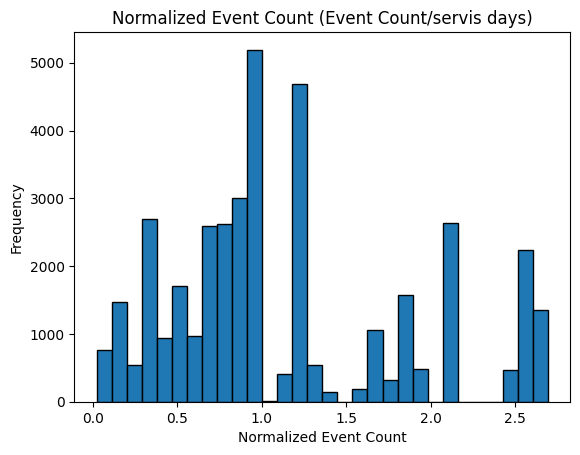

In [ ]:


plt.hist(df['Normalized Event Count'], bins=30, edgecolor='black')

plt.title('Normalized Event Count (Event Count/servis days)')
plt.xlabel('Normalized Event Count')
plt.ylabel('Frequency')

# Show the plot
plt.show()


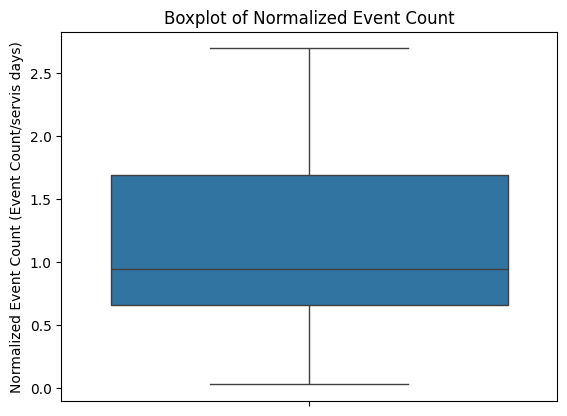

In [ ]:
sns.boxplot(y=df['Normalized Event Count'])
plt.title('Boxplot of Normalized Event Count')
plt.ylabel('Normalized Event Count (Event Count/servis days)')
plt.show()


## Calculate the *mean* 'Normalized Event Count' for each 'Station Name'

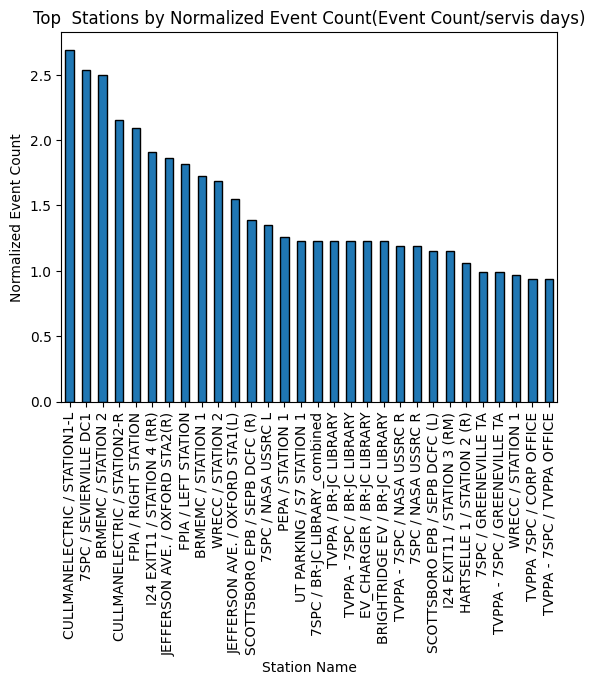

In [ ]:
# Calculate the mean 'Normalized Event Count' for each 'Station Name'
station_event_count = df.groupby('Station Name')['Normalized Event Count'].mean()


top_stations = station_event_count.sort_values(ascending=False).head(30)
top_stations.plot(kind='bar', edgecolor='black')

plt.title('Top  Stations by Normalized Event Count(Event Count/servis days)')
plt.xlabel('Station Name')
plt.ylabel('Normalized Event Count')
plt.show()

In [ ]:
df['Normalized Event Count'].isnull()

NameError: name 'df' is not defined

In [ ]:
columns = ['Station Name', 'MAC Address', 'Org Name', 'Address 1', 'City', 'State/Province',
           'Zip/Postal Code', 'Driver Zip/Postal Code', 'User ID', 'Latitude', 'Longitude', 'Port Type', "DC", "L2" ,
           'Start_Time_EST','End_charging_time', 'End_Time_EST', 'time_difference_session','Total Duration','Charging Time',
           'Time_Difference',"previous_end_time","Is_Weekday","Is_Weekend", 'Total Duration (hh:mm:ss)', 'Charging Time (hh:mm:ss)',
           'Energy (kWh)', 'GHG Savings (kg)', 'Gasoline Savings (gallons)', 'Fee', 'Start SOC', 'End SOC',
           'System S/N', 'Model Number', 'Vehicle MAC ID','Port Number','Plug Type','EVSE ID', 'Ended By']

new_columns = columns + ['parking_label']
new_df = pd.DataFrame(columns=new_columns)

for index, row in df.iterrows():
    new_df = new_df.append(row, ignore_index=True)

    session_row = row.copy()

    if index % 2 == 1 and row['Time_Difference'] > 0:
        session_row['parking_label'] = 1
    else:
        session_row['parking_label'] = 0

    new_df = new_df.append(session_row, ignore_index=True)




<ipython-input-11-eff742374b4f>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
<ipython-input-11-eff742374b4f>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(session_row, ignore_index=True)


In [ ]:
duplicated_df = df.copy()

duplicated_df['Parking_Label'] = 'p'

new_df = pd.concat([df, duplicated_df], keys=['original', 'duplicated'])

new_df = new_df.sort_index(level=1)

new_df = new_df.reset_index(drop=True)



In [ ]:
new_df['Parking_Label'] = new_df['Parking_Label'].fillna('CH')


In [ ]:
new_df.loc[new_df['Parking_Label']=='P', 'Start_Time_EST']= 0

In [ ]:
new_df.loc[new_df['Parking_Label']=='CH', 'End_Time_EST']=0

In [ ]:
#  "CH" ---> Start_Time_EST to End_charging_time, End_Time_EST=0,        "P" ---> End_charging_time to  End_Time_EST , Start_Time_EST=0

# Unique hash id and hashing

In [ ]:
# Concatenate multiple columns to create a unique session ID.=
new_df['Session_ID'] = new_df['User ID'].astype(str) + '_' + new_df['Start_Time_EST'].astype(str) + '_' + new_df['End_Time_EST'].astype(str) + '_'+ new_df['EVSE ID'].astype(str)


In [ ]:
import hashlib

def create_hash(session_id):
    return hashlib.sha256(session_id.encode()).hexdigest()

new_df['Session_ID_Hash'] = new_df['Session_ID'].apply(create_hash)


In [ ]:
# Check for duplicates in the 'Session_ID' column
duplicates = new_df.duplicated(subset=['Session_ID_Hash'], keep=False)

# Print rows where duplicates occur
#print(new_df[duplicates])


# Normalization